In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

For this stage, we will fit 2 models to use as benchmark models:

* **First model**: We will fit a linear regression with all the features, only performing a standard scaling.
* **Second model**: we will perform a power transformation to obtain gaussian variables and then proceed with a feature selection to identify the ost relevant variables

For both models, we will use the iterative imputer provided by scikit-learn to fill NaN's that are present.

In [3]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.feature_selection import (
    RFE,
    SelectKBest,
    f_regression,
)
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    RepeatedKFold,
    GridSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler


from urbana.features import normaltests
from urbana.constants import DIR_REPO, DIR_DATA, RANDOM_STATE
from urbana.models.plot_predictions import PredictedAccuracy
from urbana.features.selection import KBestSelector

cmap = sns.diverging_palette(230, 20, as_cmap=True)

In [4]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

YEAR = 2017  # Years allowed: [2017, 2018]
MONTH = 7

OUTPUT_WARNINGS = False
SAVE_FIGS = False
SAVE_MODEL = False

VARIABLE_TO_PREDICT = "Airbnb_Number"

K_EDUCATION = 1
K_AGE = 2
K_NATIONALITY = 2
K_RENT = 1
K_POI = 10

In [5]:
if not OUTPUT_WARNINGS:
    import warnings

    warnings.filterwarnings("ignore")

# Parameter Check

In [6]:
ALLOWED_YEARS = [2017, 2018]

if YEAR not in ALLOWED_YEARS:
    raise Exception("Please select a year within: {}".format(ALLOWED_YEARS))

if YEAR == 2018 and MONTH == 3:
    raise Exception(
        "Month 3 (March) is not available for 2018. Please choose a different month."
    )

In [7]:
# Create folders to store the data

DIR_VAR = DIR_DATA / "processed/{}".format(VARIABLE_TO_PREDICT)
DIR_MONTH = DIR_VAR / "{}_{:02d}".format(YEAR, MONTH)
DIR_LINEAR = DIR_MONTH / "01_linear"

if SAVE_FIGS is True or SAVE_MODEL is True:
    folder_list = [DIR_VAR, DIR_MONTH, DIR_LINEAR]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

In [8]:
PATH_TO_FILE = DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH)
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "00acquisition.ipynb" with the same date and "SAVE_DATA" set to True'
    )

# Target variable

In [9]:
np.random.seed(RANDOM_STATE)

sect = pd.read_csv(
    DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH),
)

sect.set_index("Tag", inplace=True)

sect.drop(["N_district", "N_neighbourhood", "N_section"], axis=1, inplace=True)

In [10]:
y = sect[VARIABLE_TO_PREDICT]

X = sect.drop(
    ["Airbnb_Number", "Airbnb_Price", "Airbnb_Price_Person", "Airbnb_Location_Score"],
    axis=1,
)

X.drop(["Percentage_Age_25_39"], axis=1, inplace=True)

In [11]:
geo_info = gpd.read_file(DIR_DATA / "interim/sections_geo.json")
geo_info.set_index("Tag", inplace=True)
geo_info[VARIABLE_TO_PREDICT] = sect[VARIABLE_TO_PREDICT]

print("Area with maximum value: " + str(geo_info[VARIABLE_TO_PREDICT].idxmax()))

Area with maximum value: 02_077


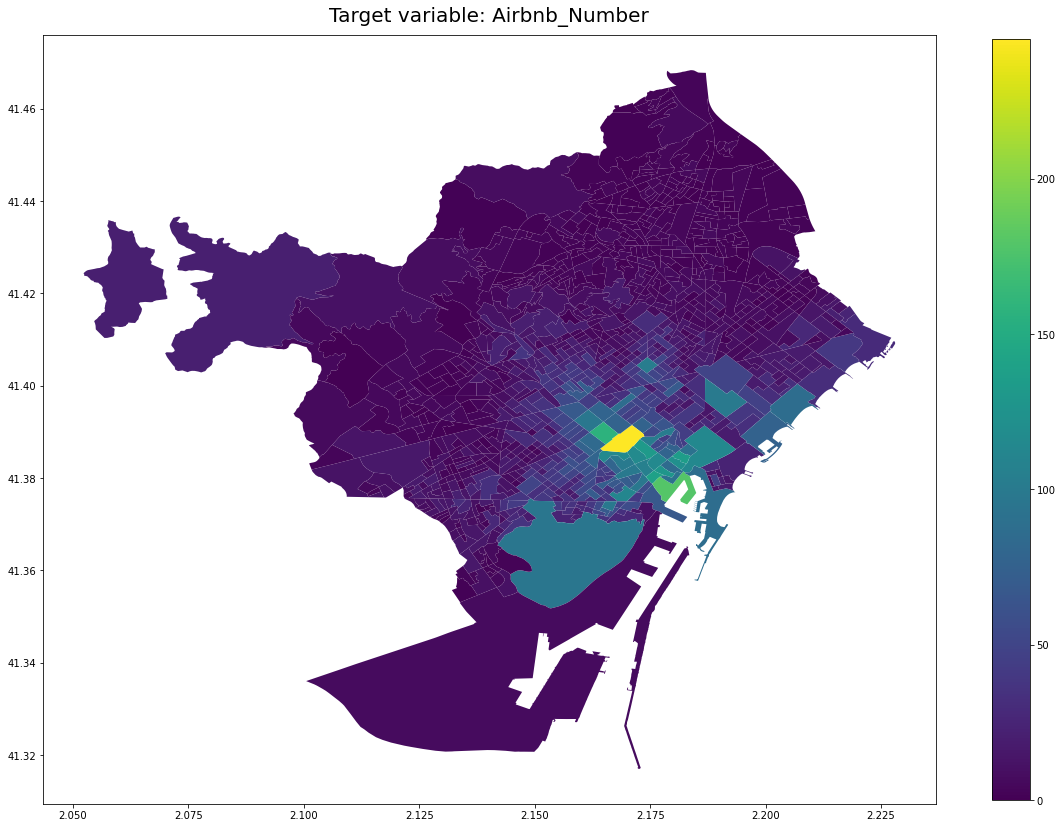

In [12]:
fig, ax = plt.subplots(figsize=(20, 20))

geo_info.plot(
    ax=ax,
    column=VARIABLE_TO_PREDICT,
    legend=True,
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Target variable: " + str(VARIABLE_TO_PREDICT), fontsize=20, y=1.01)

if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR / "target_variable.svg", format="svg")

plt.show()

# First model: All features

## Pipeline fit

In [13]:
pt = PowerTransformer()
preprocessor = Pipeline(steps=[("imputer", KNNImputer()), ("scaler", StandardScaler())])

pipe_all = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression()),
    ]
)

## Sensitivity analysis

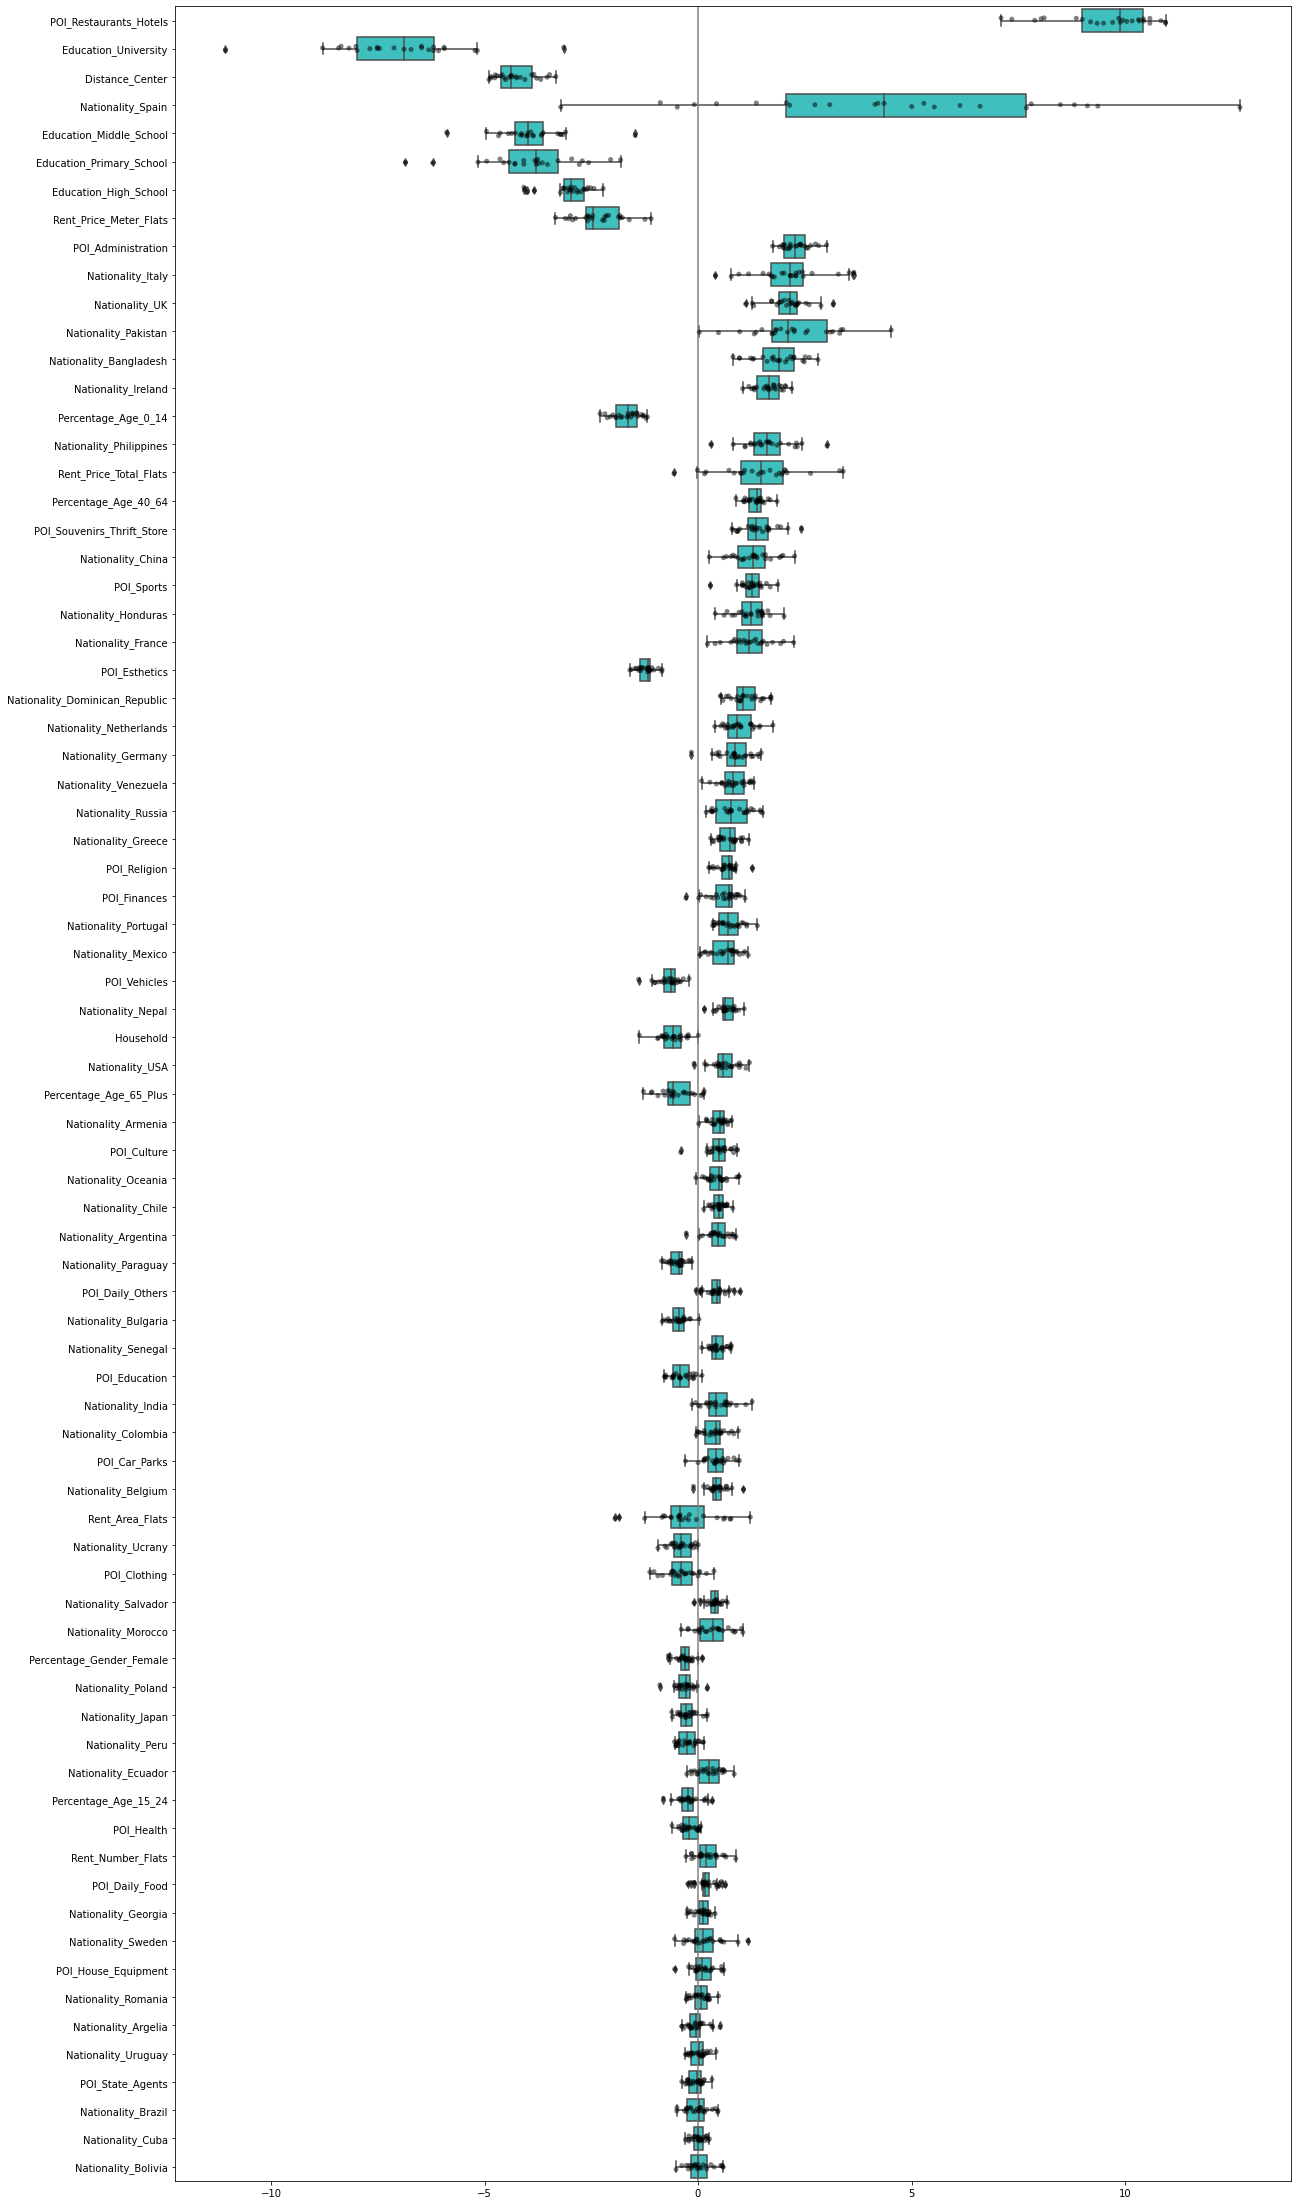

In [14]:
cv_all = cross_validate(
    pipe_all,
    X,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    scoring=["neg_root_mean_squared_error"],
    return_estimator=True,
    n_jobs=-1,
)

coefs_all = pd.DataFrame(
    [est.named_steps["regressor"].coef_ for est in cv_all["estimator"]],
    columns=X.columns,
)

medians_all = coefs_all.median()
medians_all = medians_all.reindex(medians_all.abs().sort_values(ascending=False).index)
coefs_all = coefs_all[medians_all.index]


plt.figure(figsize=(20, 40))
sns.stripplot(data=coefs_all, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs_all, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")

if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR / "all_coefficients.svg", format="svg")

plt.show()

# Second model: Transformations and feature selection

## Normality tests

In [15]:
# Check which variables are already normal
normality_test = normaltests.get_normaltest_df(X.T)

print(normality_test["dagostino"].value_counts())
print(normality_test["shapiro"].value_counts())

False    77
Name: dagostino, dtype: int64
False    77
Name: shapiro, dtype: int64


## Preprocessing Pipeline

The preprocessing will have two phases:
* KNNImputer: To imput missing data by fitting knn (better than imputing the mean or the median)
* PowerTransformer: Since none of the features is Gaussian, we will transform them with the *Yeo-Johnson* transformation

In [16]:
pt = PowerTransformer()
preprocessor = Pipeline(steps=[("imputer", KNNImputer()), ("pt", pt)])

## Feature Selection by Subgroups

In [17]:
selector = KBestSelector(
    score_func=f_regression, preprocessor=preprocessor, power_transformer=pt, y=y
)

In [18]:
X_Education = X.filter(regex="^Education")
X_Education_chosen = selector.k_best_selection(features=X_Education, k=K_EDUCATION)

In [19]:
X_Age = X.filter(regex="^Percentage_Age_")
X_Age_chosen = selector.k_best_selection(features=X_Age, k=K_AGE)

In [20]:
X_Nationality = X.filter(regex="^Nationality_")
X_Nationality_chosen = selector.k_best_selection(
    features=X_Nationality, k=K_NATIONALITY
)

In [21]:
X_Rent = X.filter(regex="^Rent_")
X_Rent_chosen = selector.k_best_selection(features=X_Rent, k=K_RENT)

In [22]:
X_POI = X.filter(regex="^POI")
X_POI_chosen = selector.k_best_selection(features=X_POI, k=K_POI)

In [23]:
X.drop(np.setdiff1d(X_Rent.columns, X_Rent_chosen), axis=1, inplace=True)

X.drop(np.setdiff1d(X_Age.columns, X_Age_chosen), axis=1, inplace=True)

X.drop(np.setdiff1d(X_Nationality.columns, X_Nationality_chosen), axis=1, inplace=True)

X.drop(np.setdiff1d(X_Education.columns, X_Education_chosen), axis=1, inplace=True)

X.drop(np.setdiff1d(X_POI.columns, X_POI_chosen), axis=1, inplace=True)

## Feature Selection Pipeline

In order to perform a feature selection, we will use *RFE* (Recursive Feature Elimination).

The number of variables to use will be a hyper-paramater that will be tuned with a GridSearch using RMSE as the metric.

The target feature will also be transformed with a PowerTransfomrer, by applying the *TransformedTargetRegressor*.

In [24]:
# Define the regressor to use
myRegressor = LinearRegression()

# Define a pipeline with the preprocessing, feature selection (RFE) and regressor
pipe_rfe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("rfe", RFE(estimator=myRegressor)),
        ("regressor", myRegressor),
    ]
)

# Define the param space for hyper-parameter tunning (in this case, the number of features to keep with RFE)
param_grid_rfe = [{"rfe__n_features_to_select": np.arange(6, 15, 1)}]

search_rfe = GridSearchCV(
    pipe_rfe, param_grid_rfe, scoring="neg_root_mean_squared_error", n_jobs=-1
)


model = TransformedTargetRegressor(regressor=search_rfe, transformer=PowerTransformer())

model.fit(X, y)

TransformedTargetRegressor(regressor=GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                                                             Pipeline(steps=[('imputer',
                                                                                              KNNImputer()),
                                                                                             ('pt',
                                                                                              PowerTransformer())])),
                                                                            ('rfe',
                                                                             RFE(estimator=LinearRegression())),
                                                                            ('regressor',
                                                                             LinearRegression())]),
                                                  n_jobs=-1,
                           

In [25]:
print("Best Model:")
print(
    "Number of features: "
    + str(model.regressor_.best_params_["rfe__n_features_to_select"])
)
print("\nList of features:")
cols_rfe = model.regressor_.best_estimator_.named_steps["rfe"].get_support(indices=True)
print(X.columns[cols_rfe])

Best Model:
Number of features: 8

List of features:
Index(['Distance_Center', 'POI_Restaurants_Hotels',
       'POI_Souvenirs_Thrift_Store', 'Percentage_Age_65_Plus',
       'Education_University', 'Nationality_Italy', 'Nationality_UK',
       'Rent_Number_Flats'],
      dtype='object')


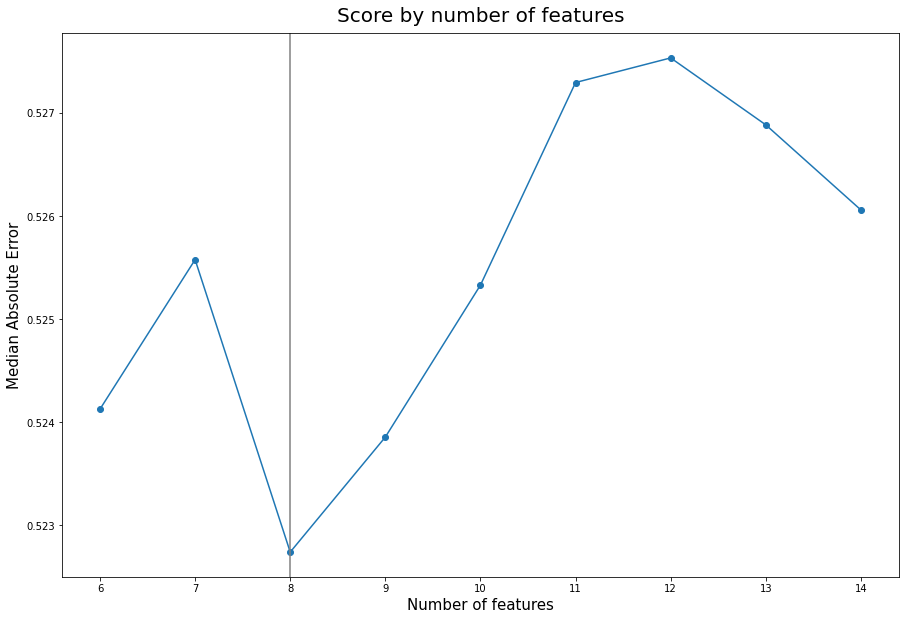

In [26]:
score_features = -model.regressor_.cv_results_["mean_test_score"]
n_features = []
for i in model.regressor_.cv_results_["params"]:
    n_features.append(i["rfe__n_features_to_select"])

id_min_score = score_features.argmin()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(n_features, score_features, marker="o")
plt.axvline(x=n_features[id_min_score], color=".5")

ax.set_xlabel("Number of features", fontsize=15)
ax.set_ylabel("Median Absolute Error", fontsize=15)
ax.set_xticks(np.arange(min(n_features), max(n_features) + 1))
ax.set_title("Score by number of features", fontsize=20, y=1.01)

if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR / "rmse.svg", format="svg")

plt.show()

In [27]:
y_pred_rfe = model.predict(X).round()
pa_rfe = PredictedAccuracy(y, y_pred_rfe)

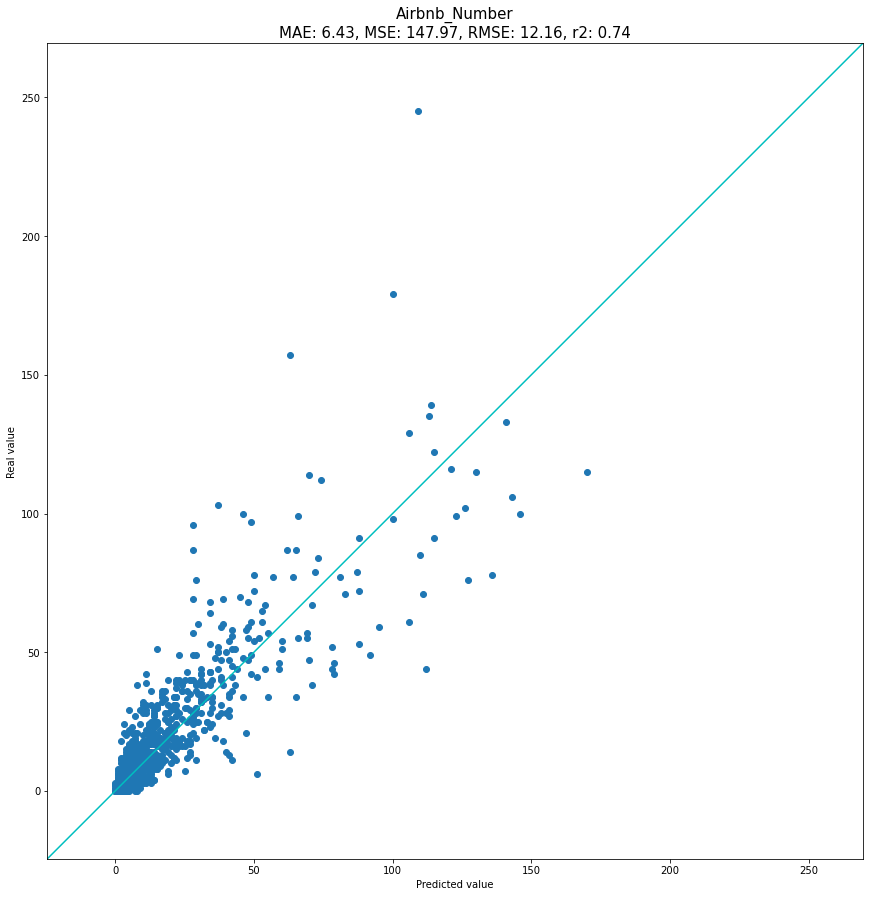

In [28]:
pa_rfe.plot_scatter(save_fig=SAVE_FIGS, root_name=DIR_LINEAR / "model")

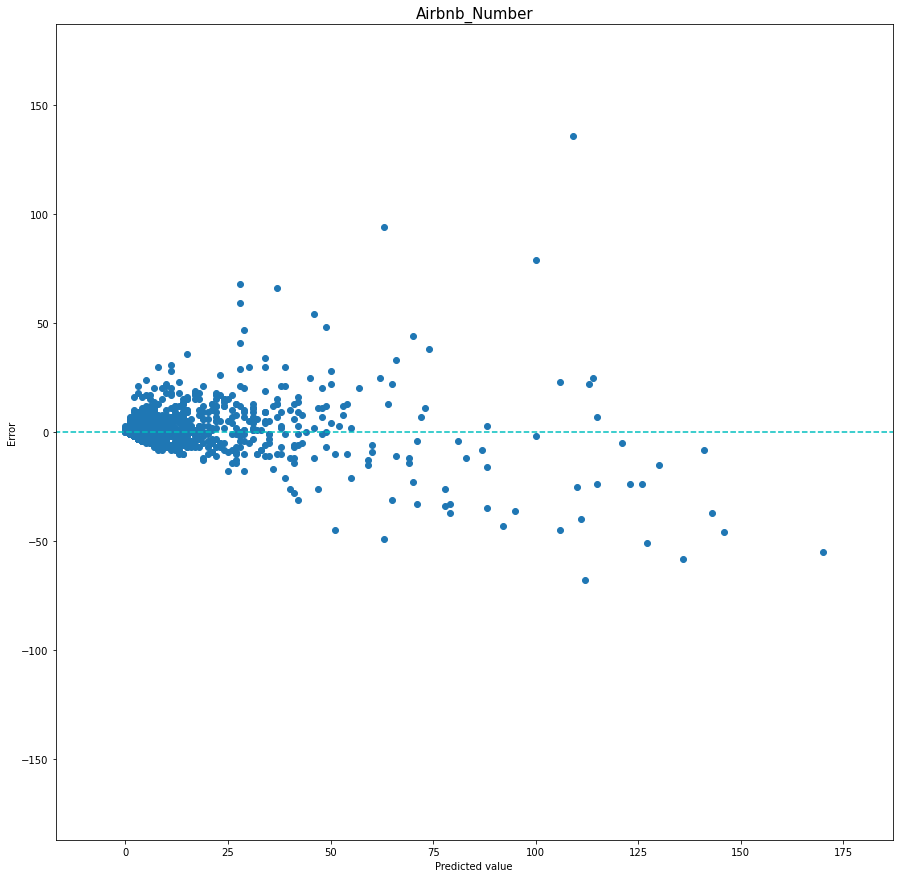

In [29]:
pa_rfe.plot_errors(save_fig=SAVE_FIGS, root_name=DIR_LINEAR / "model")

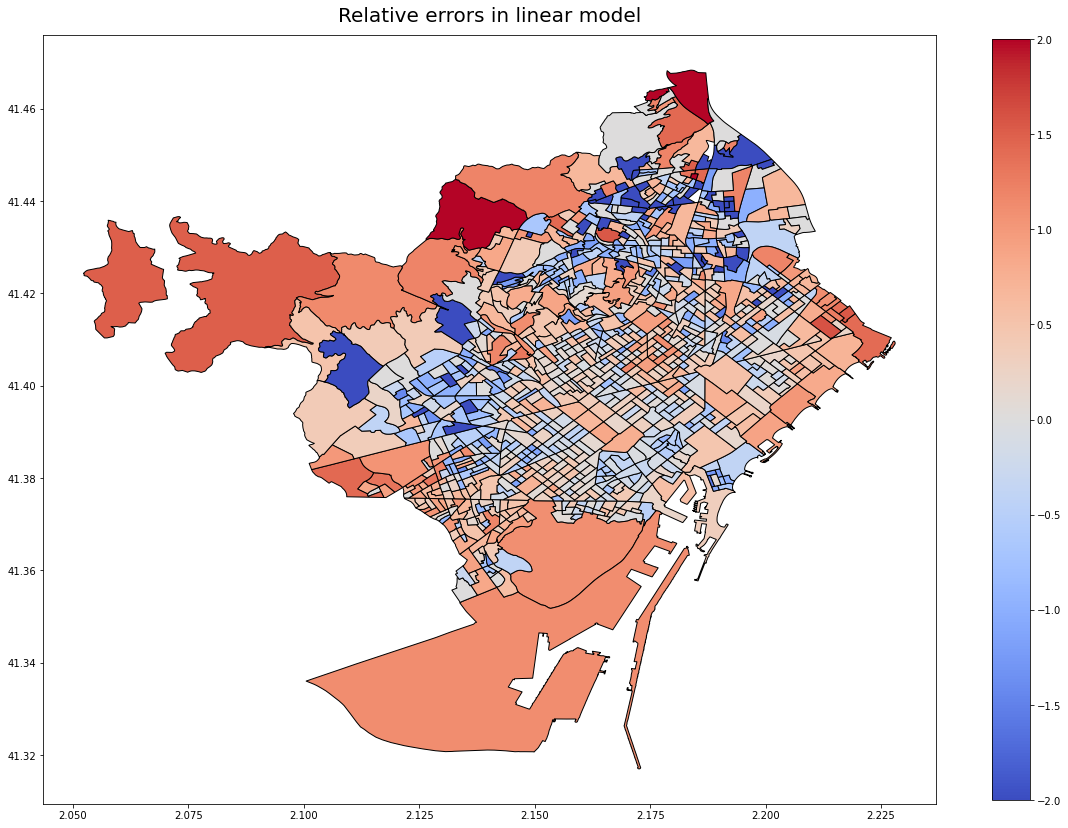

In [30]:
geo_info["Chosen_Error"] = 2 * (y - y_pred_rfe) / (abs(y) + abs(y_pred_rfe))

col_lim = max(abs(geo_info["Chosen_Error"].min()), abs(geo_info["Chosen_Error"].max()))

fig, ax = plt.subplots(figsize=(20, 20))

geo_info.plot(
    ax=ax,
    column="Chosen_Error",
    legend=True,
    figsize=(20, 20),
    edgecolor="black",
    cmap="coolwarm",
    vmin=-col_lim,
    vmax=col_lim,
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Relative errors in linear model", fontsize=20, y=1.01)


if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR / "relative_errors.svg", format="svg")

plt.show()

In [31]:
if SAVE_MODEL is True:
    geo_info[["Chosen_Error"]].to_csv(DIR_LINEAR / "relative_errors.csv")
    pd.DataFrame(y_pred_rfe, index=geo_info.index, columns=["Predictions"]).to_csv(
        DIR_LINEAR / "predictions.csv"
    )

In [32]:
pw = PowerTransformer()
pw.fit(y.values.reshape(-1, 1))

####################Tranform y_hat####################
y_pred_transformed = model.predict(X)
y_pred_transformed = pw.transform(y_pred_transformed.reshape(-1, 1)).flatten()

####################Trasform y####################
# y_test_transformed = pd.Series(pw.transform(y_test.values.reshape(-1, 1)).flatten())
y_transformed = pd.Series(pw.transform(y.values.reshape(-1, 1)).flatten())
y_transformed.name = "Transformed Airbnb_Number"

pa_rfe = PredictedAccuracy(y_transformed, y_pred_transformed)

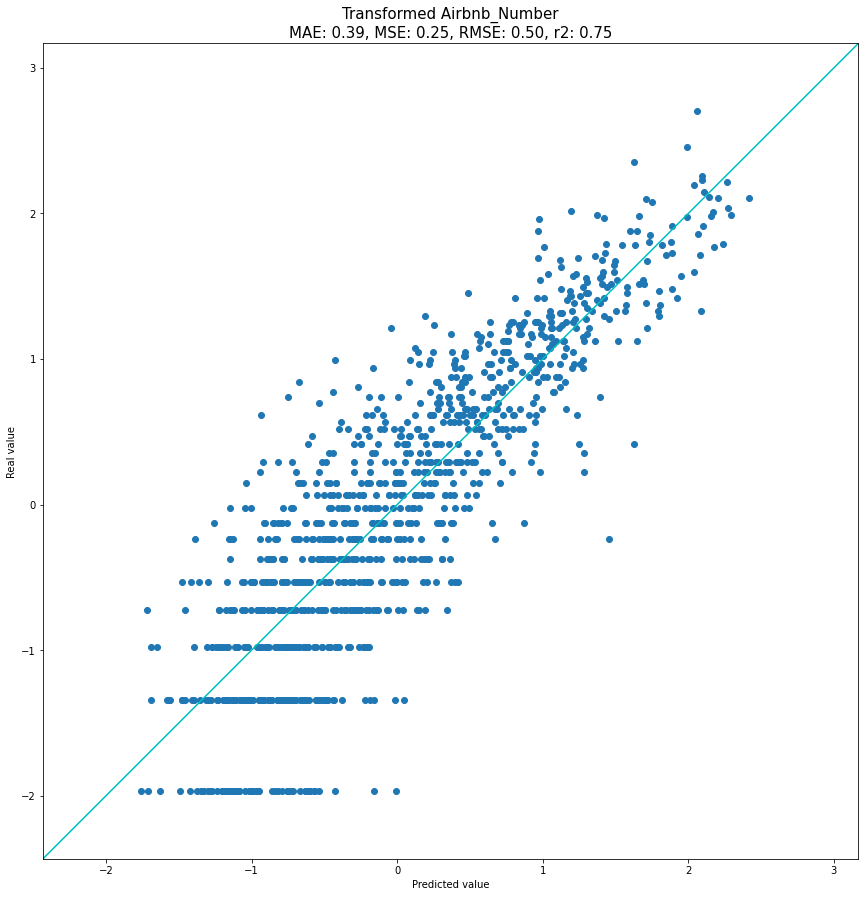

In [33]:
pa_rfe.plot_scatter(
    save_fig=SAVE_FIGS,
    root_name=DIR_LINEAR / "transformed_model",
)

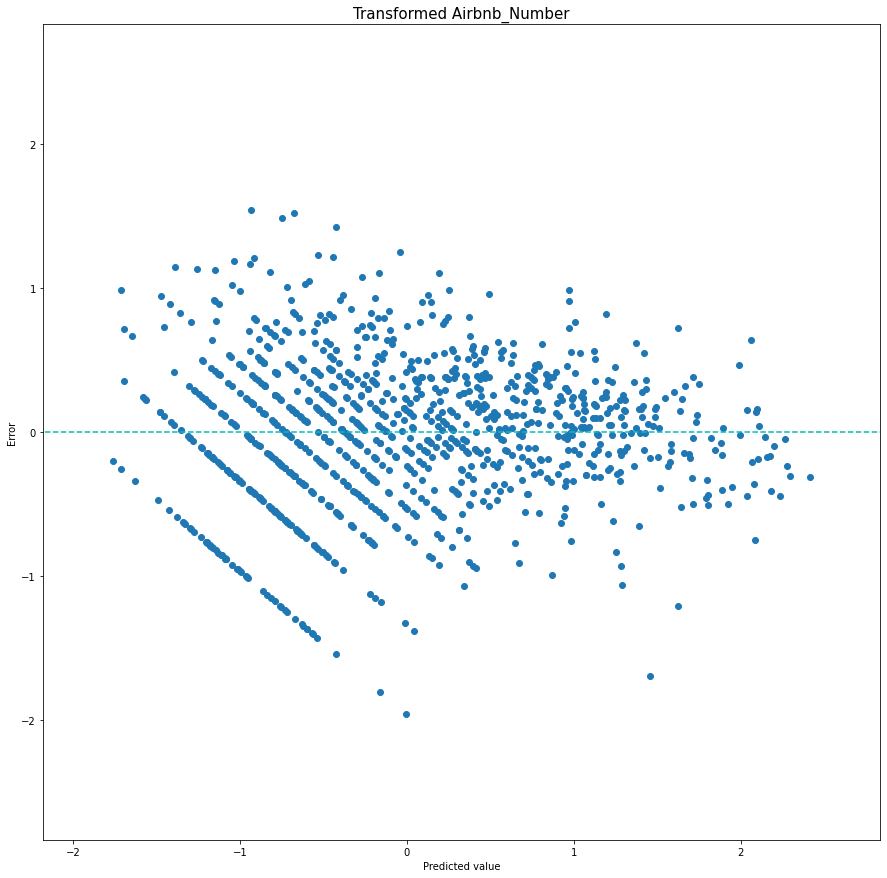

In [34]:
pa_rfe.plot_errors(
    save_fig=SAVE_FIGS,
    root_name=DIR_LINEAR / "transformed_model",
)

# Sensitivity Analysis

In [35]:
X_rfe = X.iloc[:, cols_rfe]

pipe_sens = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", myRegressor)])

model_sens = TransformedTargetRegressor(
    regressor=pipe_sens, transformer=PowerTransformer()
)

model_sens.fit(X_rfe, y)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('imputer',
                                                                       KNNImputer()),
                                                                      ('pt',
                                                                       PowerTransformer())])),
                                                     ('regressor',
                                                      LinearRegression())]),
                           transformer=PowerTransformer())

In [36]:
cv_rfe = cross_validate(
    model_sens,
    X_rfe,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    scoring=["neg_root_mean_squared_error"],
    return_estimator=True,
    n_jobs=-1,
)

coefs_rfe = pd.DataFrame(
    [est.regressor_.named_steps["regressor"].coef_ for est in cv_rfe["estimator"]],
    columns=X_rfe.columns,
)

coefs_rfe["Intercept"] = pd.Series(
    [est.regressor_.named_steps["regressor"].intercept_ for est in cv_rfe["estimator"]]
)

medians_rfe = coefs_rfe.drop(["Intercept"], axis=1).median()
medians_rfe = medians_rfe.reindex(medians_rfe.abs().sort_values(ascending=False).index)
medians_rfe = medians_rfe.append(pd.Series({"Intercept": 0}, index=["Intercept"]))
coefs_rfe = coefs_rfe[medians_rfe.index]

limit_value = (
    max(abs(coefs_rfe.to_numpy().min()), abs(coefs_rfe.to_numpy().max())) * 1.05
)

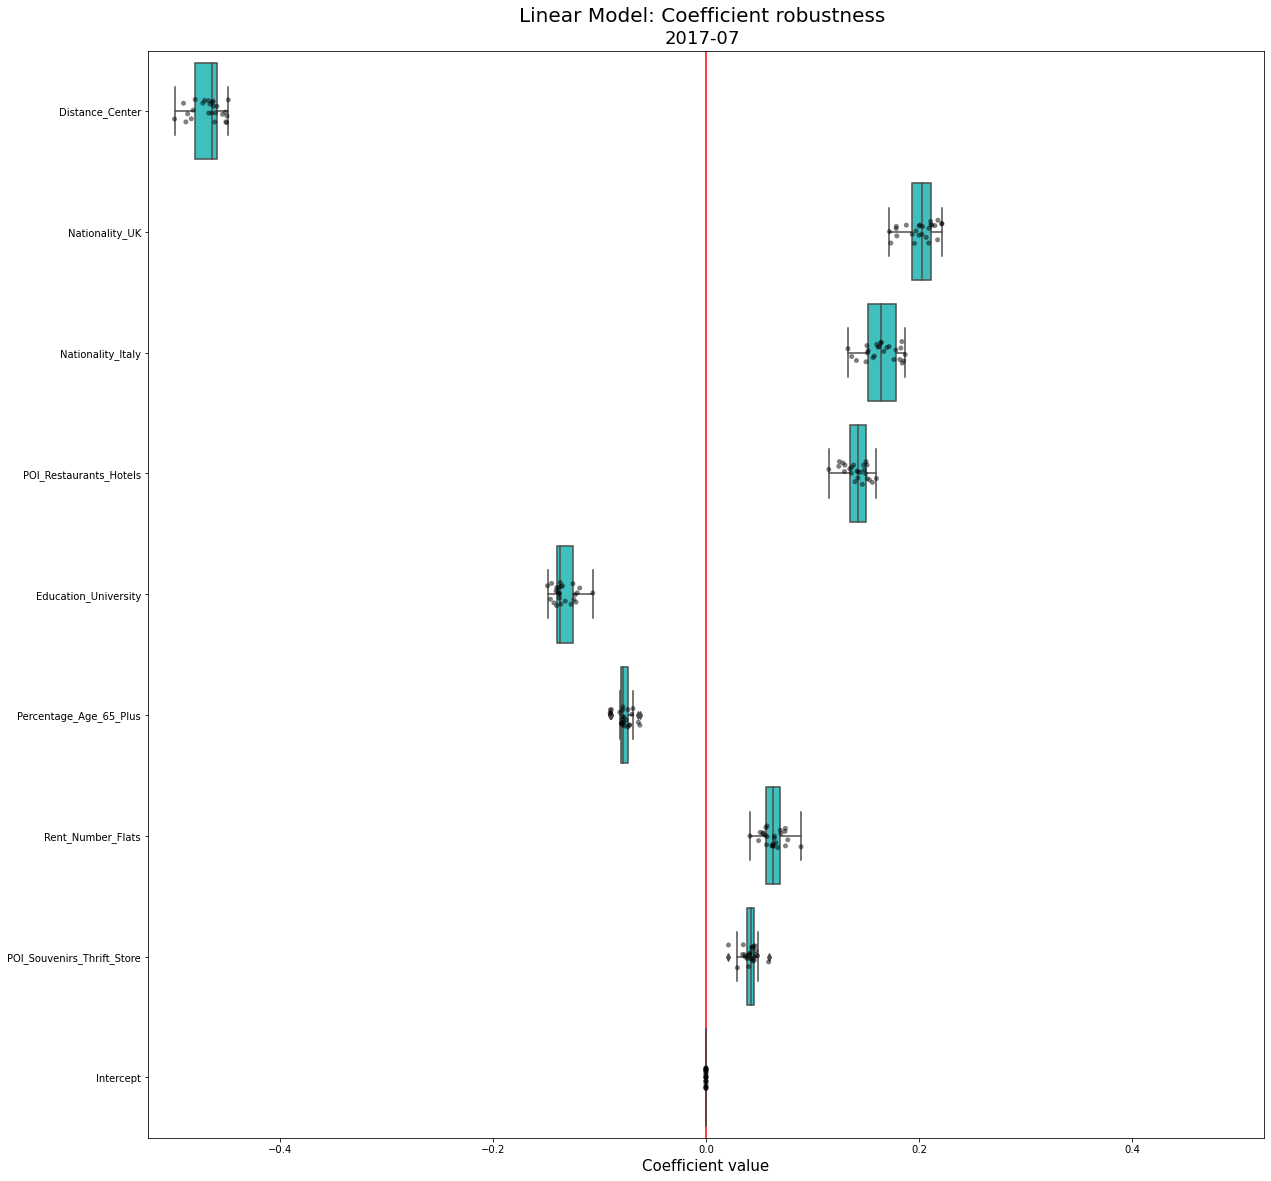

In [37]:
fig, ax = plt.subplots(figsize=(20, 20))

sns.stripplot(ax=ax, data=coefs_rfe, orient="h", color="k", alpha=0.5)
sns.boxplot(ax=ax, data=coefs_rfe, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color="red")

plt.figtext(0.51, 0.9, "Linear Model: Coefficient robustness", fontsize=20, ha="center")
plt.figtext(
    0.51,
    0.885,
    "{}-{:02d}".format(YEAR, MONTH),
    fontsize=18,
    ha="center",
)
ax.set_xlim(-limit_value, limit_value)
ax.set_xlabel("Coefficient value", fontsize=15)

if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR / "sensitivity.svg", format="svg")

plt.show()

In [38]:
if SAVE_MODEL is True:
    coefs_rfe.to_csv(DIR_LINEAR / "coefficients.csv")
    coefs_rfe.to_csv(
        DIR_VAR / "01_linear/coefficients_{}_{:02d}.csv".format(YEAR, MONTH)
    )

# Watermark

In [39]:
%load_ext watermark

In [40]:
# NBVAL_IGNORE_OUTPUT
%watermark -a "Ernesto Gregori" -u -d -t -v -m -g -wb

Author: Ernesto Gregori

Last updated: 2021-06-18 11:22:49

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.8.0-50-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: f6d607e7c801d2aae8ddd87dc91f5b49c47d8da1

Git branch: egregorimar/gwr

Watermark: 2.2.0



In [41]:
# NBVAL_IGNORE_OUTPUT
%watermark -iv

seaborn   : 0.11.1
matplotlib: 3.3.4
pandas    : 1.2.3
geopandas : 0.9.0
numpy     : 1.20.2
urbana    : 0.1.0

